In [ ]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [ ]:
import torchvision.datasets
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 130679589.01it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 106539748.31it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 51229204.64it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21027073.70it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
from torchsummary import summary

In [ ]:
X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [ ]:
X_train.dtype, y_train.dtype

(torch.uint8, torch.int64)

In [ ]:
X_train = X_train.float()
X_test = X_test.float()

In [ ]:
X_train.shape, X_test.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [ ]:
y_train.shape, y_test.shape

(torch.Size([60000]), torch.Size([10000]))

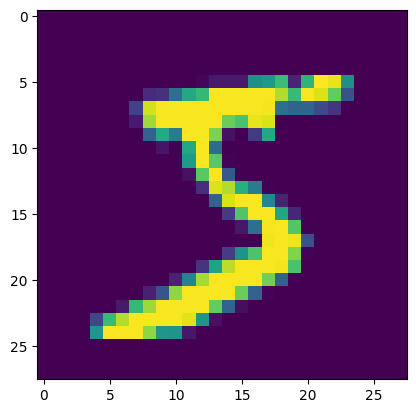

tensor(5)


In [ ]:
import matplotlib.pyplot as plt
plt.imshow(X_train[0, :, :])
plt.show()
print(y_train[0])

In [ ]:
X_train = X_train.reshape([-1, 28 * 28])
X_test = X_test.reshape([-1, 28 * 28])

In [ ]:
class MNISTNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(MNISTNet, self).__init__()
        self.fc1 = torch.nn.Linear(28 * 28, n_hidden_neurons)
        self.ac1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, 10)

    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        return x

mnist_net = MNISTNet(100)

In [ ]:
torch.cuda.is_available()

True

In [ ]:
# !nvidia-smi

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
mnist_net = mnist_net.to(device)

In [ ]:
summary(mnist_net, input_size=(1, 784))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 100]          78,500
           Sigmoid-2               [-1, 1, 100]               0
            Linear-3                [-1, 1, 10]           1,010
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.30
Estimated Total Size (MB): 0.31
----------------------------------------------------------------


In [ ]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mnist_net.parameters(), lr=1.0e-3)

In [ ]:
batch_size = 100

test_accuracy_history = []
test_loss_history = []

X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(5):
    order = np.random.permutation(len(X_train))

    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()

        batch_indexes = order[start_index:start_index+batch_size]

        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)

        preds = mnist_net.forward(X_batch)

        loss_value = loss(preds, y_batch)
        loss_value.backward()

        optimizer.step()

    test_preds = mnist_net.forward(X_test)
    test_loss_history.append(loss(test_preds, y_test).cpu().detach().numpy())

    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean()
    test_accuracy_history.append(accuracy.cpu().detach().numpy())
    print(accuracy)

tensor(0.9240, device='cuda:0')
tensor(0.9238, device='cuda:0')
tensor(0.9294, device='cuda:0')
tensor(0.9266, device='cuda:0')
tensor(0.9305, device='cuda:0')


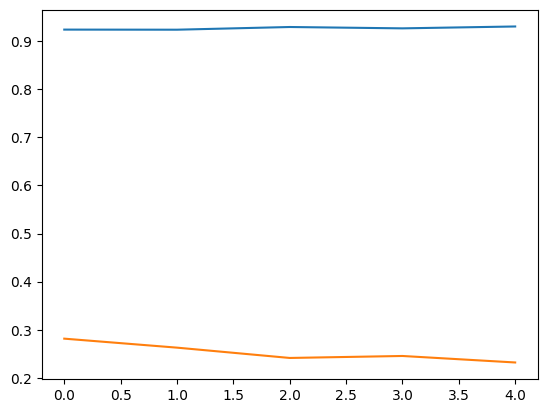

In [ ]:
plt.plot(test_accuracy_history)
plt.plot(test_loss_history)